# Bootstrap Calibrations

In [1]:
%matplotlib inline

In [2]:
# imports
try:
    import seaborn as sns; sns.set(context="notebook",font_scale=2)
except:
    pass

from desispec import bootcalib as desiboot
from desiutil import funcfits as dufits
from astropy.io import fits
from astropy.stats import sigma_clip

import numpy as np
from astropy.modeling import models, fitting

/Users/xavier/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Find peaks

In [3]:
# Read flat
flat_hdu = fits.open('/Users/xavier/DESI/Wavelengths/pix-b0-00000001.fits')
header = flat_hdu[0].header
flat = flat_hdu[0].data

In [4]:
reload(desiboot)
xpk, ypos, cut = desiboot.find_fiber_peaks(flat)#,debug=True)

INFO:bootcalib.py:660:find_fiber_peaks: starting


INFO:DESI:starting


INFO:bootcalib.py:697:find_fiber_peaks: Found 500 fibers


INFO:DESI:Found 500 fibers


INFO:bootcalib.py:705:find_fiber_peaks: Found 20 bundles


INFO:DESI:Found 20 bundles


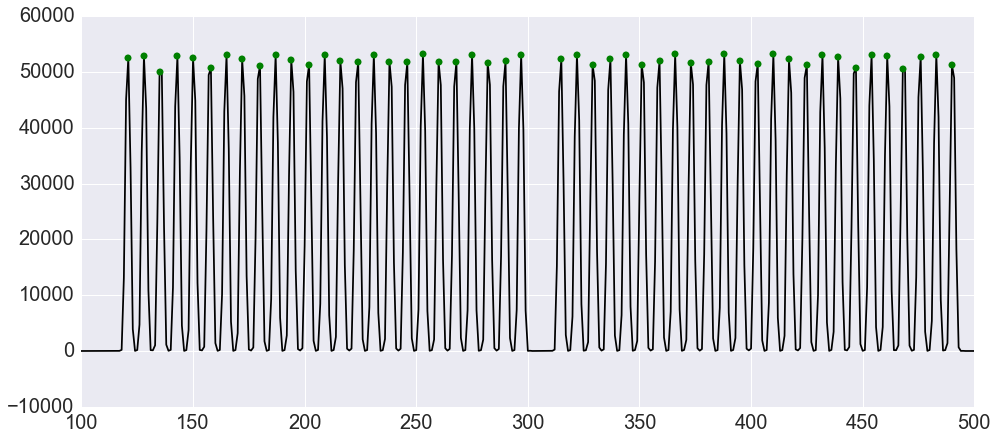

In [5]:
# Check
plt.clf()
plt.figure(figsize=(16,7))
xplt = np.arange(cut.size)
plt.plot(xplt,cut, 'k-')
plt.plot(xpk, cut[xpk],'go')
plt.xlim(100,500)
plt.show()
plt.close()

## Trace the flat spectra

### Crude estimate (flux weighted centroid)

In [6]:
reload(desiboot)
xset, xerr = desiboot.trace_crude_init(flat,xpk[0:50],ypos)

### Polynomial fits (test)

In [7]:
yval = np.arange(4096)
ii=4
xval = xset[:,ii]
gdval = xerr[:,ii] < 999.
dfit0 = dufits.func_fit(yval[gdval],xval[gdval],'legendre',6)

In [8]:
fitv = dufits.func_val(yval,dfit0)

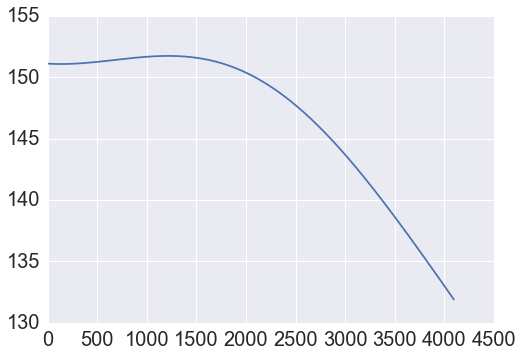

In [9]:
# Fit
xdb.xplot(yval,fitv, xtwo=yval,ytwo=xset[:,ii],mtwo='+')

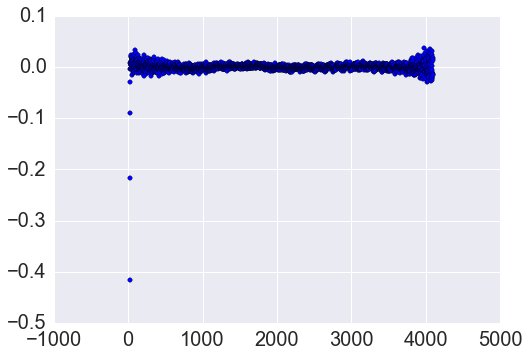

In [10]:
# Residuals
xdb.xplot(yval[gdval],fitv[gdval]-xval[gdval], scatter=True)

### Polynomial fits (True)

In [11]:
reload(desiboot)
xfit, fdicts = desiboot.fit_traces(xset,xerr)#[:,0:5],xerr[:,0:5])

### QA

In [13]:
reload(desiboot)
desiboot.qa_fiber_trace(flat,xfit)

Writing fiber_trace_qa.pdf QA for fiber trace


## PSF

### Sigma for each fiber (initial guess)

In [14]:
reload(desiboot)
gauss = desiboot.fiber_gauss(flat,xfit,xerr)#,verbose=True)#,debug=True)

INFO:bootcalib.py:583:fiber_gauss: Working on fiber 0 of 50


INFO:DESI:Working on fiber 0 of 50


INFO:bootcalib.py:583:fiber_gauss: Working on fiber 25 of 50


INFO:DESI:Working on fiber 25 of 50


### Fit a 2nd Order Polynomial

In [15]:
fiber = np.arange(gauss.size)
gfdict,mask = dufits.iter_fit(fiber, gauss, 'polynomial', 2)

In [16]:
gfdict

{'coeff': array([  1.13912985e+00,  -6.26732640e-03,   1.93205792e-04]),
 'func': 'polynomial',
 'order': 2,
 'xmax': 49,
 'xmin': 0}

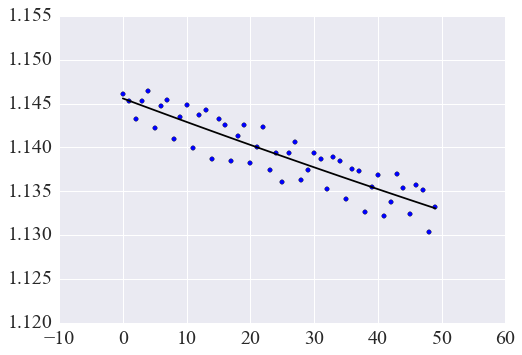

In [17]:
plt.clf()
plt.scatter(fiber,gauss)
plt.plot(fiber, dufits.func_val(fiber,gfdict),'k-')
#plt.xlim(100,500)
plt.show()
plt.close()

## Extract Arc (one fiber at a time)

### Load Image

In [18]:
arc_hdu = fits.open('/Users/xavier/DESI/Wavelengths/pix-b0-00000000.fits')
arc = arc_hdu[0].data
header = arc_hdu[0].header

### Extract

In [19]:
reload(desiboot)
all_spec = desiboot.extract_sngfibers_gaussianpsf(arc,xfit,gauss)
all_spec.shape

0
10
20
30
40


(4096, 50)

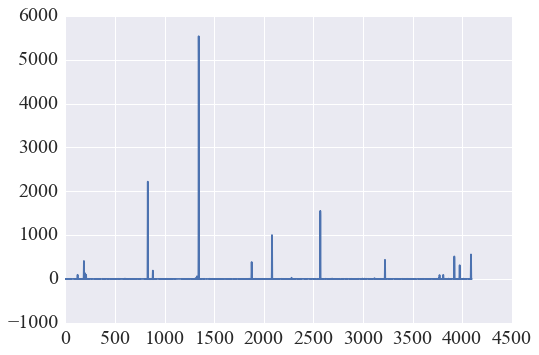

In [20]:
xdb.xplot(np.arange(all_spec[:,0].size), all_spec[:,0])#, sv_aspec[1], sv_aspec[2])

## Wavelength info

In [ ]:
# Dispersion
import desimodel.io

In [ ]:
desi_psf = desimodel.io.load_psf('b')

In [ ]:
desi_psf.wdisp(0,4500.) # fiber, wavelength

In [ ]:
wave0 = desi_psf.wavelength(0,np.arange(desi_psf.npix_y))

In [ ]:
np.max(wave0)

In [ ]:
med_bdisp = np.median(desi_psf.wdisp(0,wave0))
med_bdisp

In [ ]:
np.median(np.abs(wave0-np.roll(wave0,1)))

In [ ]:
xdb.xplot(wave0,desi_psf.wdisp(0,wave0))

In [ ]:
desi_psf.npix_x, desi_psf.npix_y

In [ ]:
poly_fit = dufits.func_fit(wave0,np.arange(desi_psf.npix_y), 'polynomial',2,xmin=0.,xmax=1.)
poly_fit

In [ ]:
xdb.xplot(wave0, np.arange(desi_psf.npix_y),dufits.func_val(wave0,poly_fit))

## Find Lines

In [21]:
reload(desiboot)
spec = all_spec[:,0]
pixpk = desiboot.find_arc_lines(spec)

In [22]:
len(pixpk)

19

In [ ]:
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(pixpk,yspec[np.round(pixpk).astype(int)],color='red')
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

## Identify Arc Lines

### Init

In [ ]:
camera = header['CAMERA']
print(camera)

### Load line list 

In [ ]:
reload(desiboot)
#llist = pypit_alines.load_arcline_list(None,None,['CdI','ArI','NeI','HgI'],wvmnx=aparm['wvmnx'])
llist = desiboot.load_arcline_list(camera)#['CdI','ArI','HgI','NeI'])

In [ ]:
llist

### Grab lines

In [ ]:
reload(desiboot)
dlamb, wmark, gd_lines = desiboot.load_gdarc_lines(camera)
dlamb, wmark, gd_lines

### Match a set of 5 gd_lines to detected lines

In [ ]:
reload(desiboot)
id_dict = desiboot.id_arc_lines(pixpk,gd_lines,dlamb,wmark)

In [ ]:
id_dict

In [ ]:
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['first_id_pix']):
    plt.text(xpixpk, yspec[np.round(xpixpk)], '{:g}'.format(id_dict['first_id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

### Idenfity additional selected lines

In [ ]:
reload(desiboot)
desiboot.add_gdarc_lines(id_dict, pixpk, gd_lines)

In [ ]:
# IDs
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

In [ ]:
# Residuals
plt.clf()
# Fit
yfit = dufits.func_val(np.array(id_dict['id_wave']),id_dict['fit'])
# IDs
plt.scatter(id_dict['id_wave'], np.array(id_dict['id_pix'])-yfit)
#
plt.xlabel('ID wave')
plt.ylabel('Residual (pixels)')
plt.show()
plt.close()

### Identify as many others as possible

In [ ]:
reload(desiboot)
desiboot.id_remainder(id_dict, pixpk, llist)

In [ ]:
# IDs
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,xpixpk in enumerate(id_dict['id_pix']):
    plt.text(xpixpk, yspec[int(np.round(xpixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

In [ ]:
# Fit with rejection
final_fit,mask = dufits.iter_fit(np.array(id_dict['id_wave']),np.array(id_dict['id_pix']),'polynomial',3,xmin=0.,xmax=1.)
final_fit_pix,mask2 = dufits.iter_fit(np.array(id_dict['id_pix']), np.array(id_dict['id_wave']),'polynomial',3,xmin=0.,xmax=1.)

In [ ]:
# Plot residuals
plt.clf()
# Fit
yfit = dufits.func_val(np.array(id_dict['id_wave']),final_fit)
# IDs
plt.scatter(id_dict['id_wave'], np.array(id_dict['id_pix'])-yfit)
#
plt.xlabel('ID wave')
plt.ylabel('Residual (pixels)')
plt.show()
plt.close()

## Generate DESI PSF output

In [ ]:
reload(desiboot)
ny = xfit.shape[0]
id_dict['final_fit'] = final_fit
id_dict['wave_min'] = dufits.func_val(0,final_fit_pix)
id_dict['wave_max'] = dufits.func_val(ny-1,final_fit_pix)
desiboot.write_psf('tmp.fits',xfit,[id_dict])